# Testing coarsening data because the summer is UGLY

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    13:17:47 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    13:17:47 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    13:17:47 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
with open('../chirp_processing/A11_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

In [57]:
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co),np.mean(r2).values,[vv,vv_err,fit,r2,slope_errs]

def optimal_window_and_leapfrog(ds,noise_floor):
    max_score = 0
    windows = np.arange(20,90,20)
    lags = np.round(np.logspace(0,3,4)).astype('int')
    co_mat = np.zeros((len(windows),len(lags)))
    r2_mat = np.zeros((len(windows),len(lags)))
    for i in range(len(windows)):
        step = windows[i] # earlier experiments show step doesn't change results by much
        #for step in [10,20,40,80]:
        #    if step <= window:
        for j in range(len(lags)):
            count,r2,res = strain_metrics(ds, windows[i], step,lags[j],noise_floor)
            print(f"Window {windows[i]}, lag {lags[j]} -> frac high co {count:.2}, r2 {r2:.2}")
            co_mat[i,j] = count
            r2_mat[i,j]=r2
            # mean coherence not relevant I think
            temp_score = count+r2
            if temp_score > max_score:
                max_score = temp_score
                to_return = windows[i],lags[j],res
            
    fig, axs = plt.subplots(ncols=2,figsize=(15,5))
    plt0 = axs[0].pcolormesh(100*co_mat)
    plt.colorbar(plt0,ax=axs[0],label='fraction of data with |coherence|>0.95')
    axs[0].set_xticks(np.arange(co_mat.shape[1]) + 0.5, minor=False)
    axs[0].set_yticks(np.arange(co_mat.shape[0]) + 0.5, minor=False)
    axs[0].set_xticklabels(lags)
    axs[0].set_yticklabels(windows)
    axs[0].set_ylabel('Correlation window size [points included]')
    axs[0].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[0].set_title('fraction of data with high coherence')

    plt1 = axs[1].pcolormesh(r2_mat)
    plt.colorbar(plt1,ax=axs[1],label='Average r^2 of linear strain fits')
    axs[1].set_xticks(np.arange(r2_mat.shape[1]) + 0.5, minor=False)
    axs[1].set_yticks(np.arange(r2_mat.shape[0]) + 0.5, minor=False)
    axs[1].set_xticklabels(lags)
    axs[1].set_yticklabels(windows)
    axs[1].set_ylabel('Correlation window size [points included]')
    axs[1].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[1].set_title('Mean strain rate fit r-squared')

    return to_return
    
def plot_strain_fit(res,xlims=None,ylims=None):
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    slope_err = res[4]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.errorbar(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,yerr=slope_err.values,linestyle='None',marker='.',ecolor='k')
    if ylims:
        ax.set_ylim(ylims)
    ax.set_ylabel('Strain rate [y$^{-1}$]')
    ax.set_title('Strain fitting results')
    ax.set_xlabel('Date')
    #plt.yscale('symlog',linthresh=1e-2)

    fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.05*len(vv.time)),len(vv.time),len(vv.time)//10)
    for i in range(10):
        time = vv.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),marker='.',linestyle='None',zorder=1)
        slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:10]}')
        if xlims:
            axs_1[i].set_xlim(xlims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

def plot_vv_2d(res,xlims=None):
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    fig, axs = plt.subplots(figsize=(20,10),nrows=2,sharex=True)
    plt1 = vv.plot(ax=axs[0],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
    axs[0].invert_yaxis()
    axs[0].set_title('Vertical velocity estimate')
    axs[0].set_xlabel('')
    plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

    plt2 = vv_err.plot(ax=axs[1],x='time',cmap='Blues')
    axs[1].invert_yaxis()
    axs[1].set_xlabel('Date')
    axs[1].set_title('Vertical velocity error')
    if xlims:
        plt.xlim(xlims)
    plt2.colorbar.set_label(label='vertical velocity error [m y$^{-1}$]', size=14)





## A11 Summer

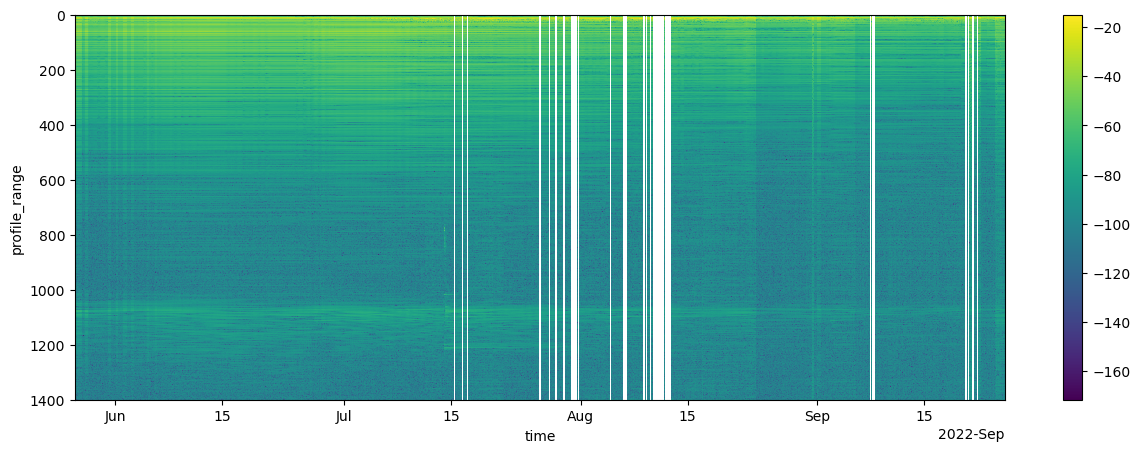

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(s22).plot(x='time')
ax.invert_yaxis()


In [69]:
time_to_interp = pd.date_range("2022-05-27 12:00", "2022-09-25 12:00", freq="15min")
interp_profiles = s22.interp(time=time_to_interp,method='linear')

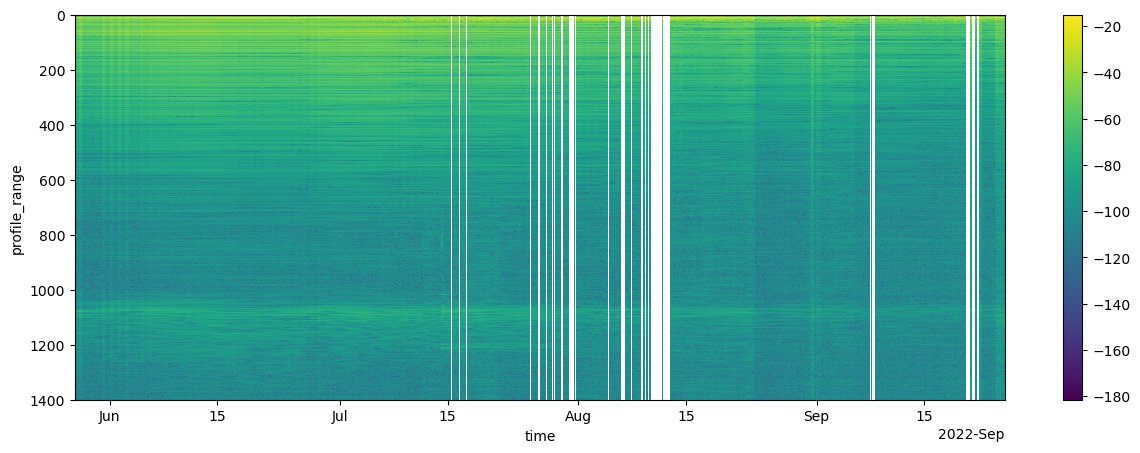

In [70]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()


In [71]:
daily_profiles = interp_profiles.coarsen(time=96,boundary='trim').mean()

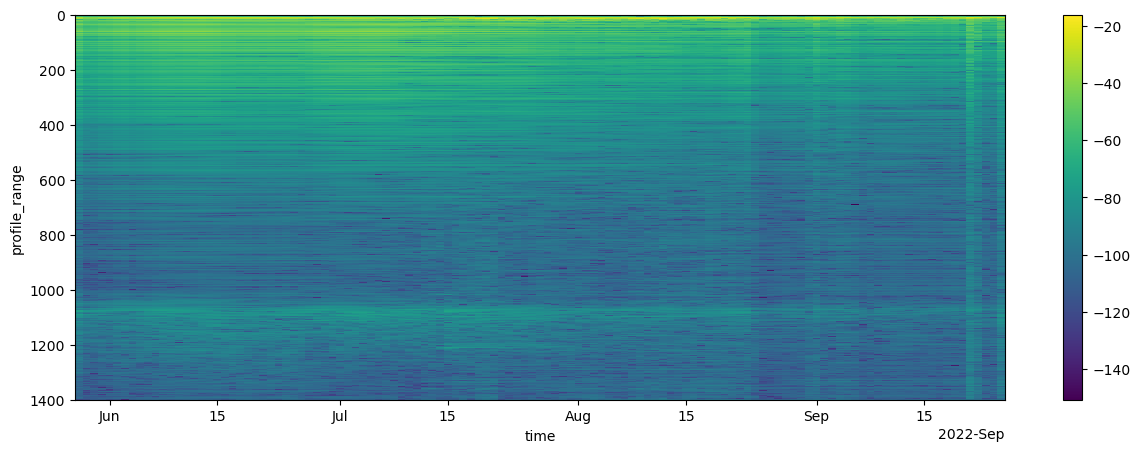

In [72]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(daily_profiles).plot(x='time')
ax.invert_yaxis()


In [73]:
count,r2,res = strain_metrics(daily_profiles, 40, 40,1,noise_floor_location)

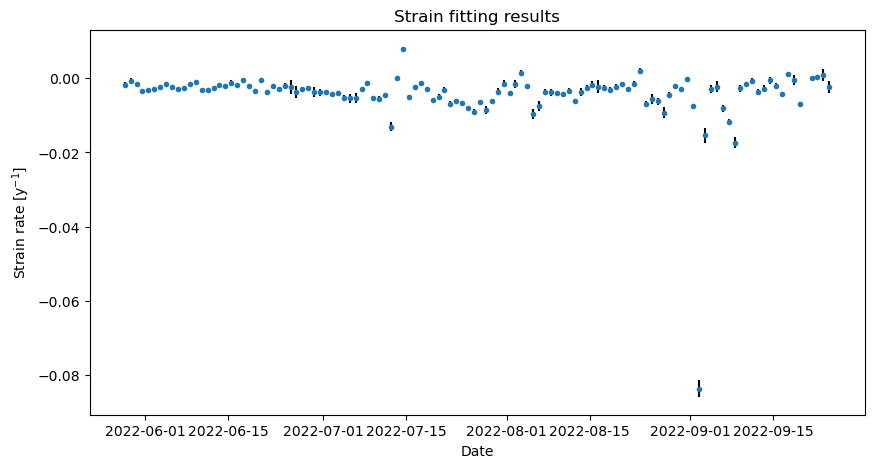

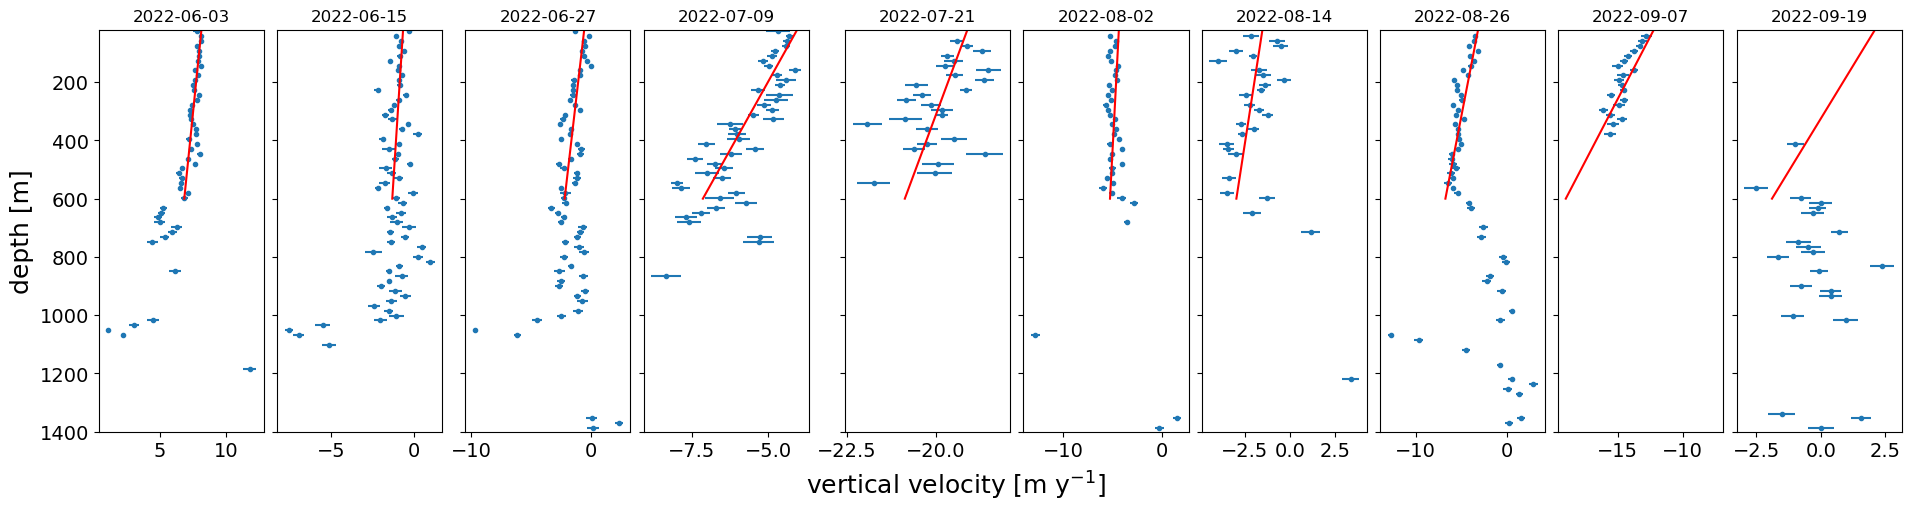

In [74]:
plot_strain_fit(res)

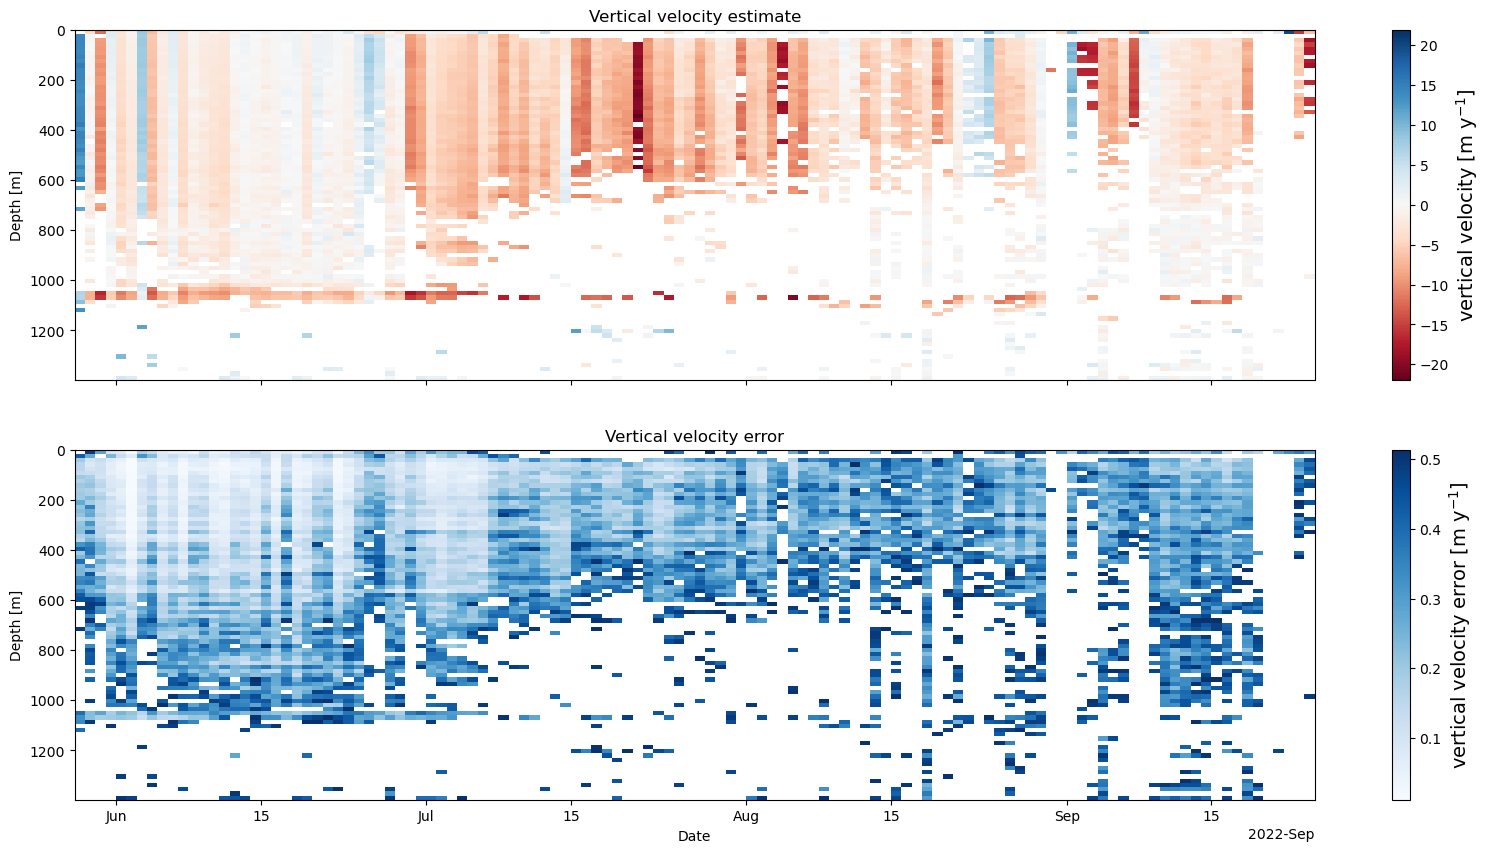

In [75]:
plot_vv_2d(res)

## Winter

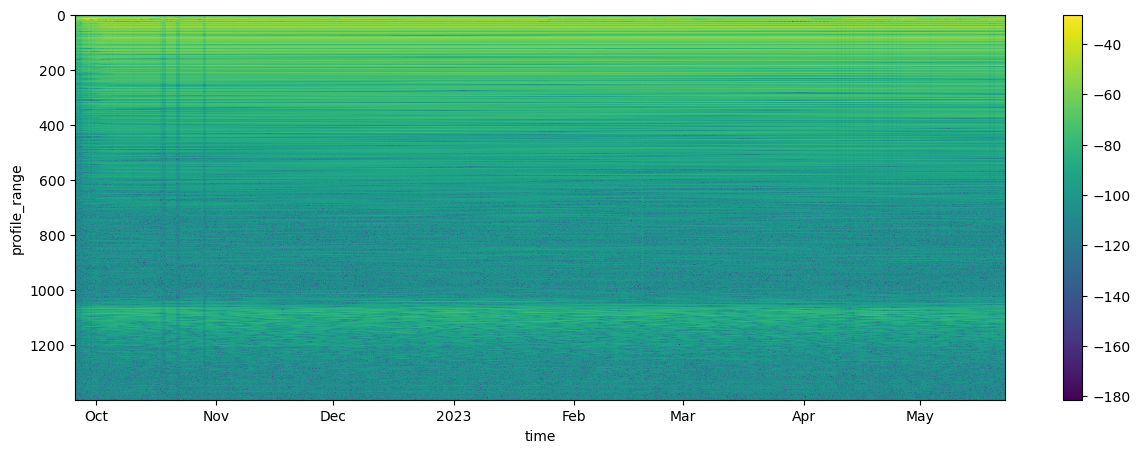

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(winter).plot(x='time')
ax.invert_yaxis()


In [43]:
time_to_interp = pd.date_range("2022-09-25 16:00", "2023-05-22 12:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')

In [64]:
daily_profiles = interp_profiles.coarsen(time=96,boundary='trim').mean()

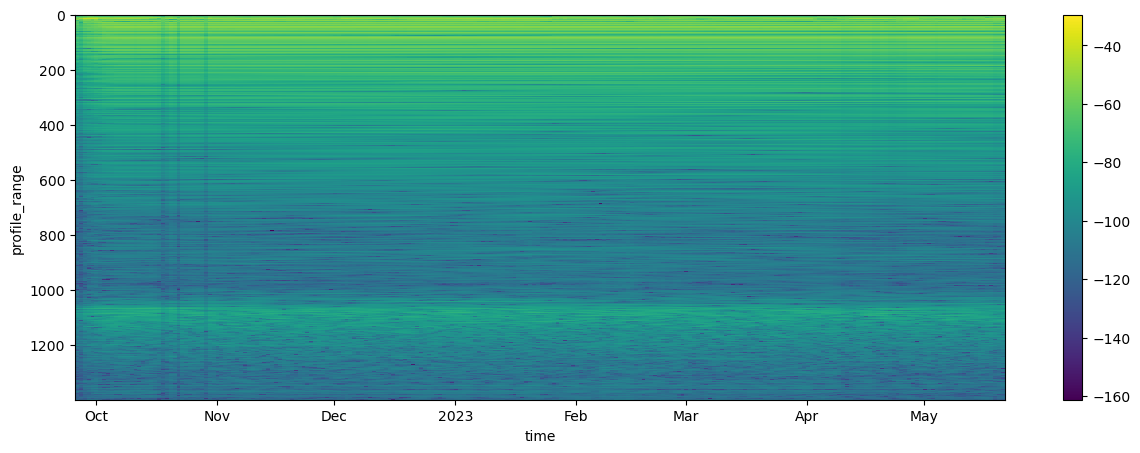

In [65]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(daily_profiles).plot(x='time')
ax.invert_yaxis()


In [66]:
count,r2,res = strain_metrics(daily_profiles, 70, 70,1,noise_floor_location)

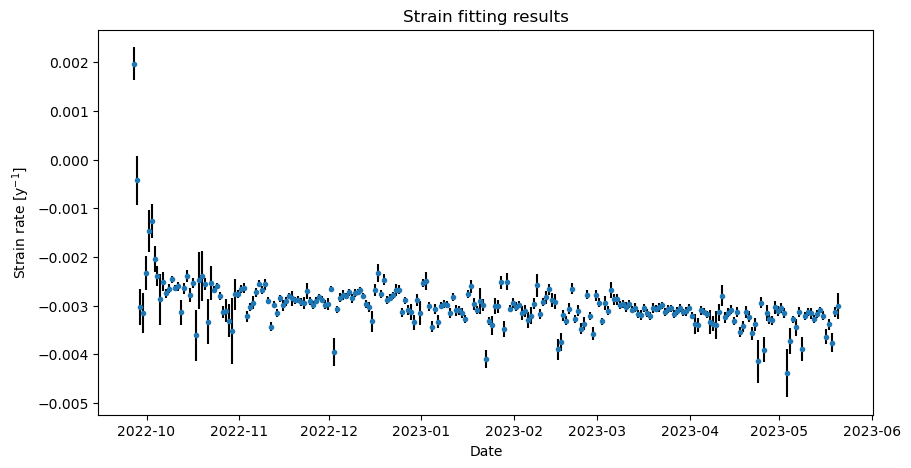

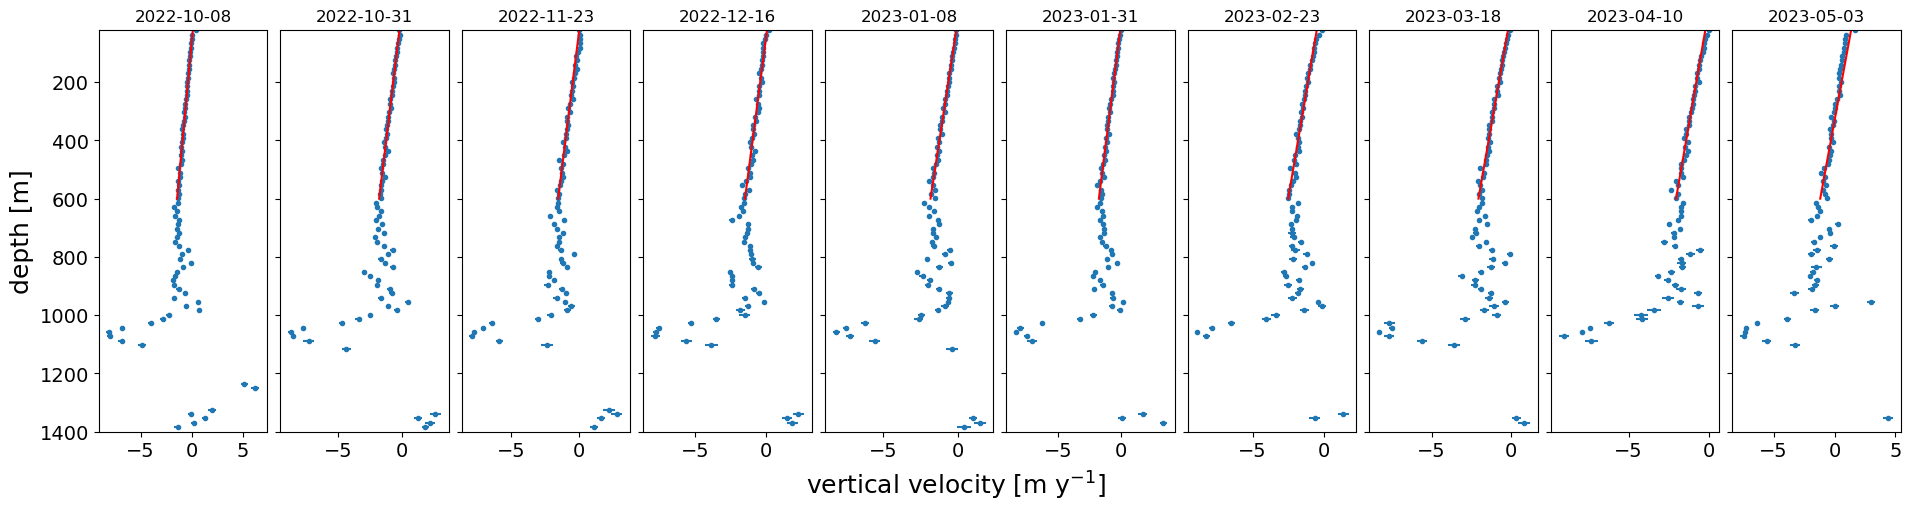

In [67]:
plot_strain_fit(res)

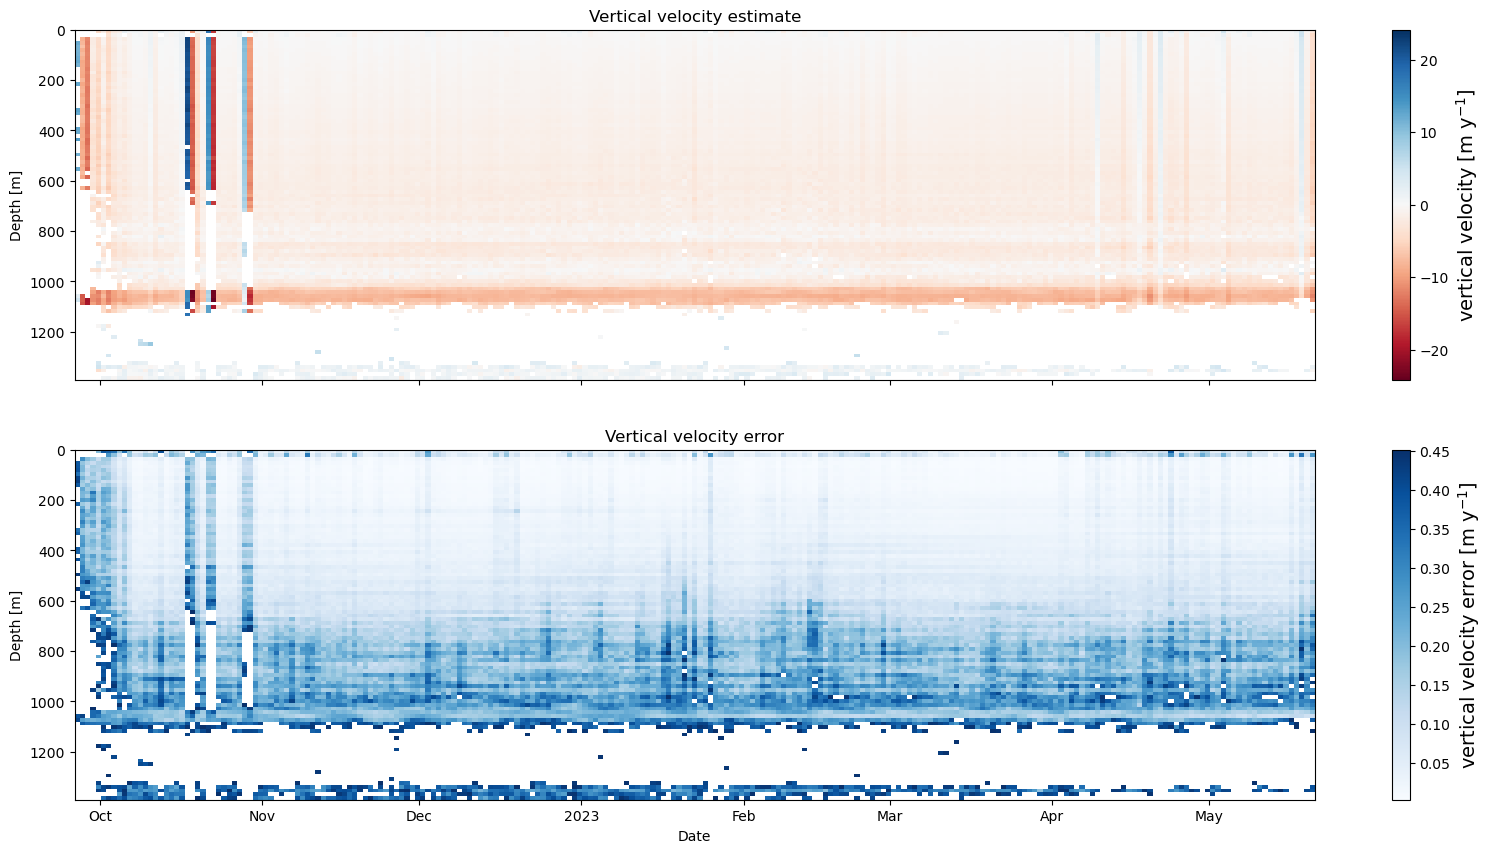

In [68]:
plot_vv_2d(res)